# Estimating grid orientation and grid spacing

This notebook deals with finding the best grid parameter for the transformation from x,y to v0,v1,v2 coordinates.

This involves the following steps.

    1.Getting our best estimates of the parameters from traditional grid cell methods (orientation and spacing from spatial autocorrelation, offset from firing rate map).
    2.Starting from the parameters of step 1, fitting the activity of the grid cell with a model of a perfect grid cell to find better parameters.
    3.Starting from the parameters of step 2, fitting the activity of the grid cell with a more flexible model that allows deviation from the perfect grid pattern.

The parameters from steps 2 and 3 are saved in a file for later use.

In [24]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np

from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To test the estimation of grid orientation and grid spacing, we can first simulate a group of grid cells as shown in the first notebook "1_Simulating grid cell spike trains.ipynb"

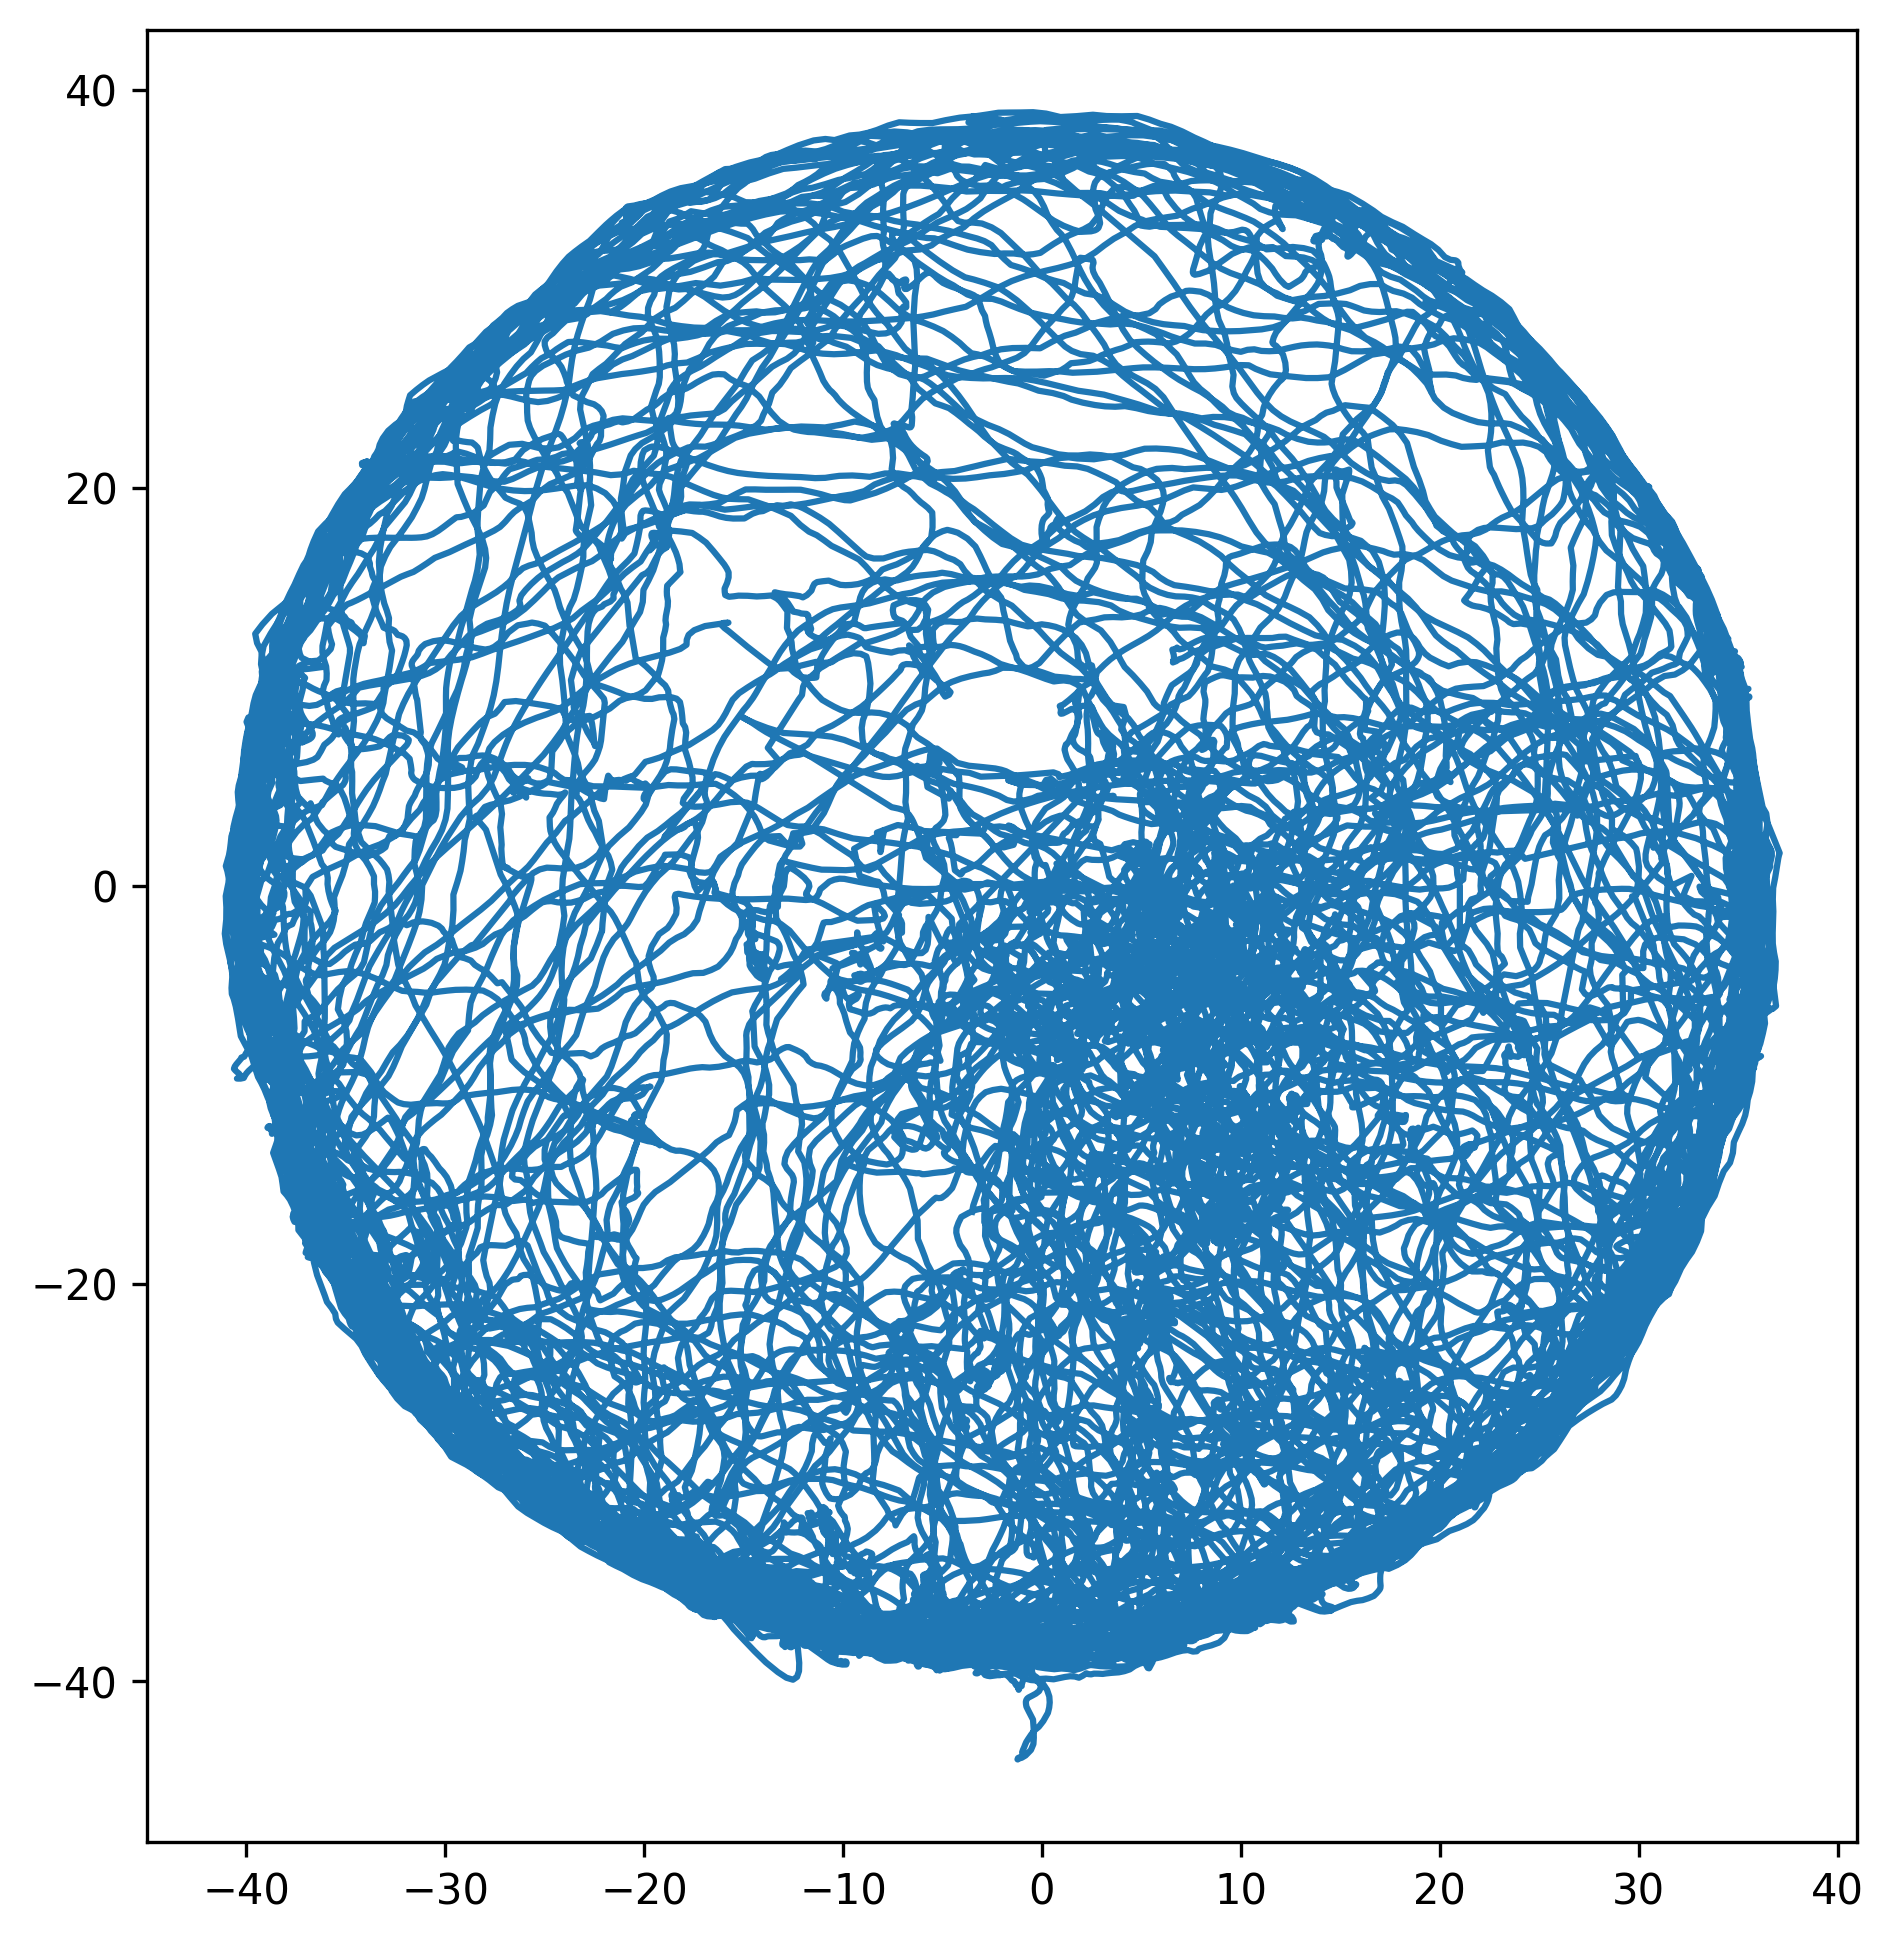

In [25]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=firstRF)


fig, ax = plt.subplots(figsize=(8,8))

ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal')  

In [26]:
grid_param = {}
grid_param["n_cells"] = 4
grid_param["orientation"] = np.array([0,np.pi/3,np.pi/3*2])
grid_spacing = 35
grid_param["period"] = np.array([grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6),grid_spacing*np.cos(np.pi/6)])
grid_param["offset"] = np.random.rand(grid_param["n_cells"],2)*grid_param["period"][0]
peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"] )
peak_rates[peak_rates<5] = 5
grid_param["peak_rate"] = peak_rates

In [27]:
neuron_list = [Simulated_grid_cell(name=f"{i}", 
                                   offset=grid_param["offset"][i,:],
                                   orientation=grid_param["orientation"],
                                   period=grid_param["period"], 
                                   peak_rate=grid_param["peak_rate"][i], ap=ap)  for i in tqdm(range(grid_param["n_cells"]))]


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


In [28]:
for n in neuron_list:
    n.spatial_properties.firing_rate_map_2d()

In [29]:
ori_inter = n.ap.intervals.inter

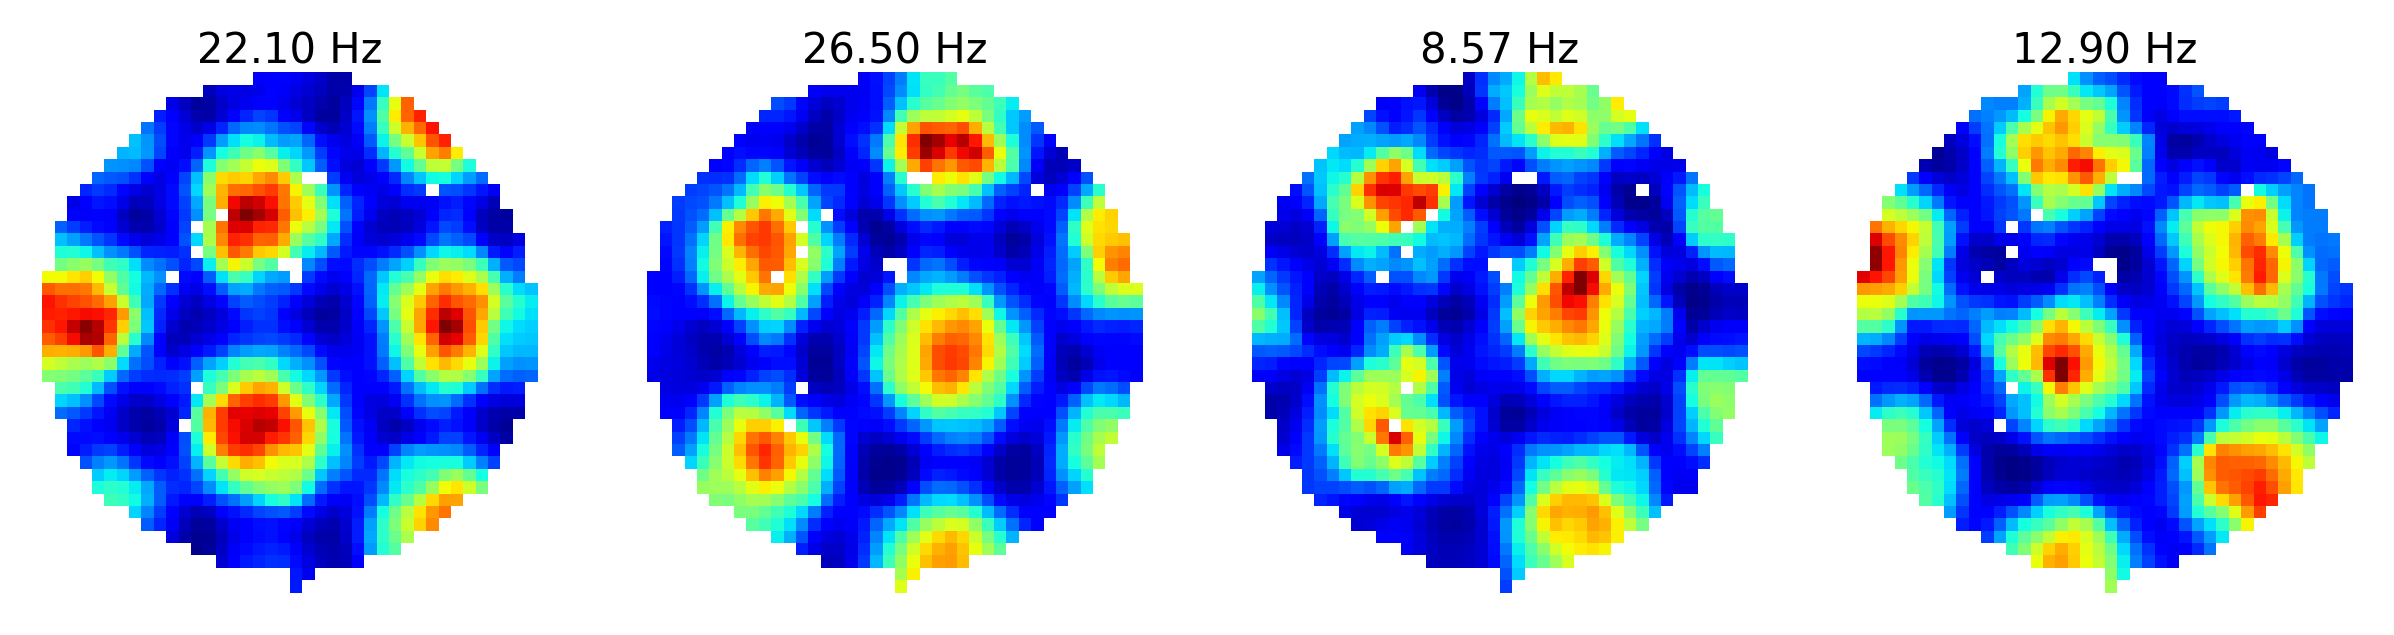

In [30]:
rowSize,colSize= 2,2
ncols=5
nrows=int(np.ceil(len(neuron_list)/ncols))
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(neuron_list):
    x = int(i/ncols)
    y = i%ncols
    ax = fig.add_subplot(mainSpec[x,y])
    plotMap(ax,n.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)))



# Find the best match for orientation and spacing

Our parameters are

    Orientation of 3 grid axes
    Period of 3 grid axes
    Peak firing rate of the neuron

Getting the best parameters will ensure that we find the best transformation of path x,y coordinate into grid cell representation coordinates.

For this transformation, we need the orientation of the 3 axes and the period along the 3 axes.

We use a grid cell model with the above parameter to predict the firing rate of the cell from the animal position. We find the best parameters using gradient descent.

Setting the initial values of the parameter to the best possible guess is important to avoid the many local minima possible when fitting the grid cell model. If we start with values that are not too far off from the solution, the model usually converges to parameters that will generate a firing rate map that is highly correlated with the original firing rate map (r > 0.9).

We don't model the difference in rate between the different fields of the grid.

In [59]:
for n in neuron_list:
    n.ap.set_intervals(ori_inter)
    n.spike_train.set_intervals(ori_inter)

In [63]:
# To start, we get an estimation of grid cell parameters using the firing rate map and spatial autocorrelation
sgc = neuron_list[0]

cm_per_bin = 3
xy_range=np.array([[-50,-90],[50,60]])

sgc.spatial_properties.firing_rate_map_2d(cm_per_bin =cm_per_bin, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)
sgc.spatial_properties.spatial_autocorrelation_map_2d(min_n_for_correlation=50,invalid_to_nan=True)
sgc.spatial_properties.grid_score()
sgc.spike_train.instantaneous_firing_rate(bin_size_sec = 0.02,sigma=1,outside_interval_solution="remove")

In [93]:
gcPeakLocation = sgc.spatial_properties.firing_rate_map_peak_location()
xy,grid_peak_location =  gcPeakLocation

In [97]:
print(gcPeakLocation)

(array([33, 22]), array([22., -2.]))


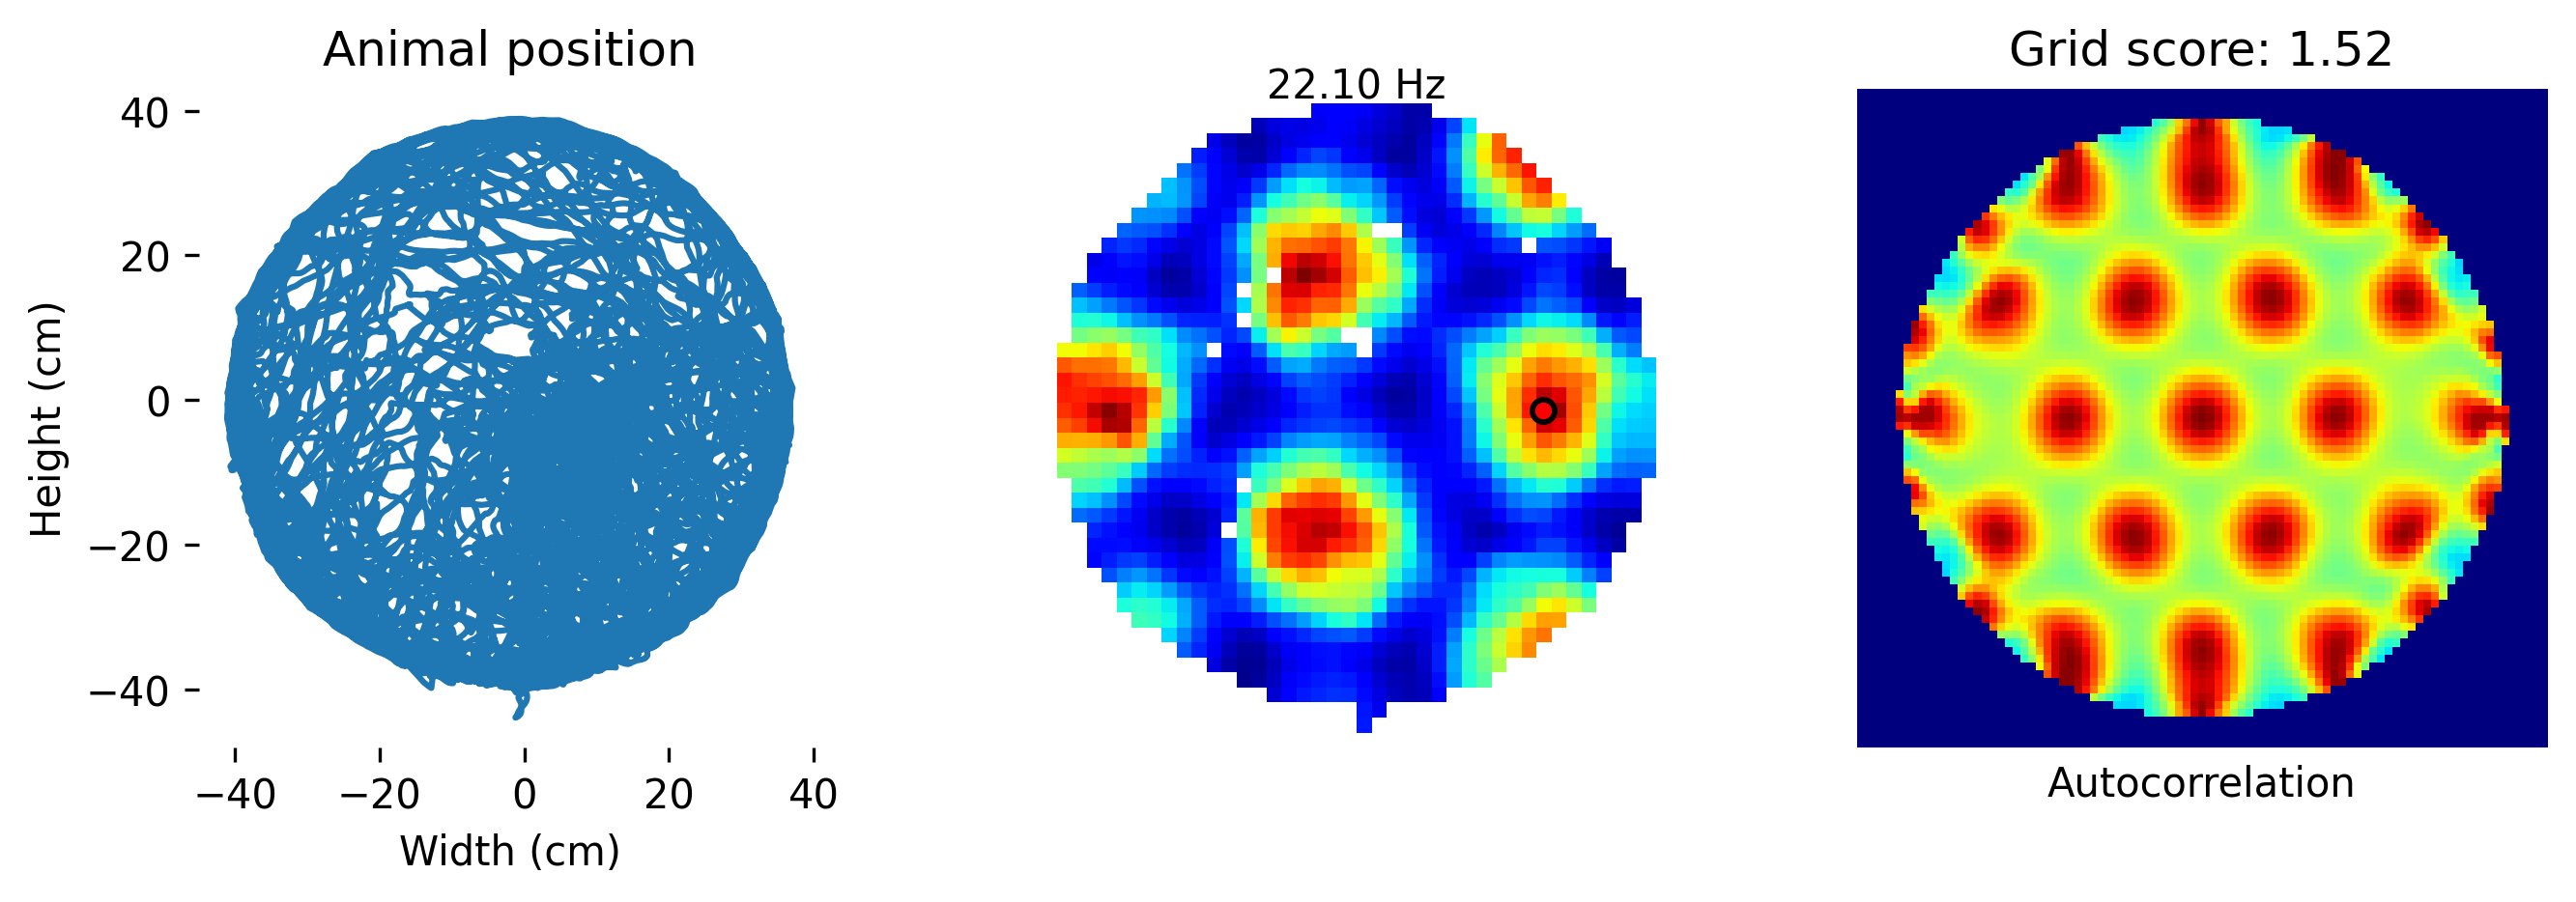

In [94]:
rowSize,colSize= 3,3
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
plt.rcParams['figure.dpi'] = 300

ax = fig.add_subplot(mainSpec[0,0])
ax.plot(ap.pose[:,1],ap.pose[:,2])
ax.set_aspect('equal') 
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Height (cm)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Animal position')

ax = fig.add_subplot(mainSpec[0,1])
sgc.spatial_properties.firing_rate_map_2d()
plotMap(ax,sgc.spatial_properties.firing_rate_map,title = "{0:.2f} Hz".format(np.nanmax(sgc.spatial_properties.firing_rate_map)))
#ax.scatter(xy[0],xy[1],color="black", s = 35)
#ax.scatter(xy[0],xy[1],color="red", s = 10)

ax = fig.add_subplot(mainSpec[0,2])
plot_spatial_autocorrelation(ax,sgc)

#fig.savefig('../img/notebook2_example_grid_cell.png')
fig.savefig('../img/notebook2_example_grid_cell_no_peak.png')

In [71]:
print(sgc.spatial_properties.grid_info())

(34.84207722337131, 0.5288876521194937, 3.770723336340417, array([[57.54078234, 53.29019072],
       [42.40786271, 61.92079496],
       [27.36708036, 53.13060424],
       [27.45921766, 35.70980928],
       [42.59213729, 27.07920504],
       [57.63291964, 35.86939576],
       [57.54078234, 53.29019072]]))


In [52]:
print(sgc.spatial_properties.points_inside_dougnut)

[(27, 35), (27, 53), (42, 27), (42, 44), (42, 61), (57, 35), (57, 53)]


In [56]:
rotatedHexagon = sgc.spatial_properties.grid_info()[3]

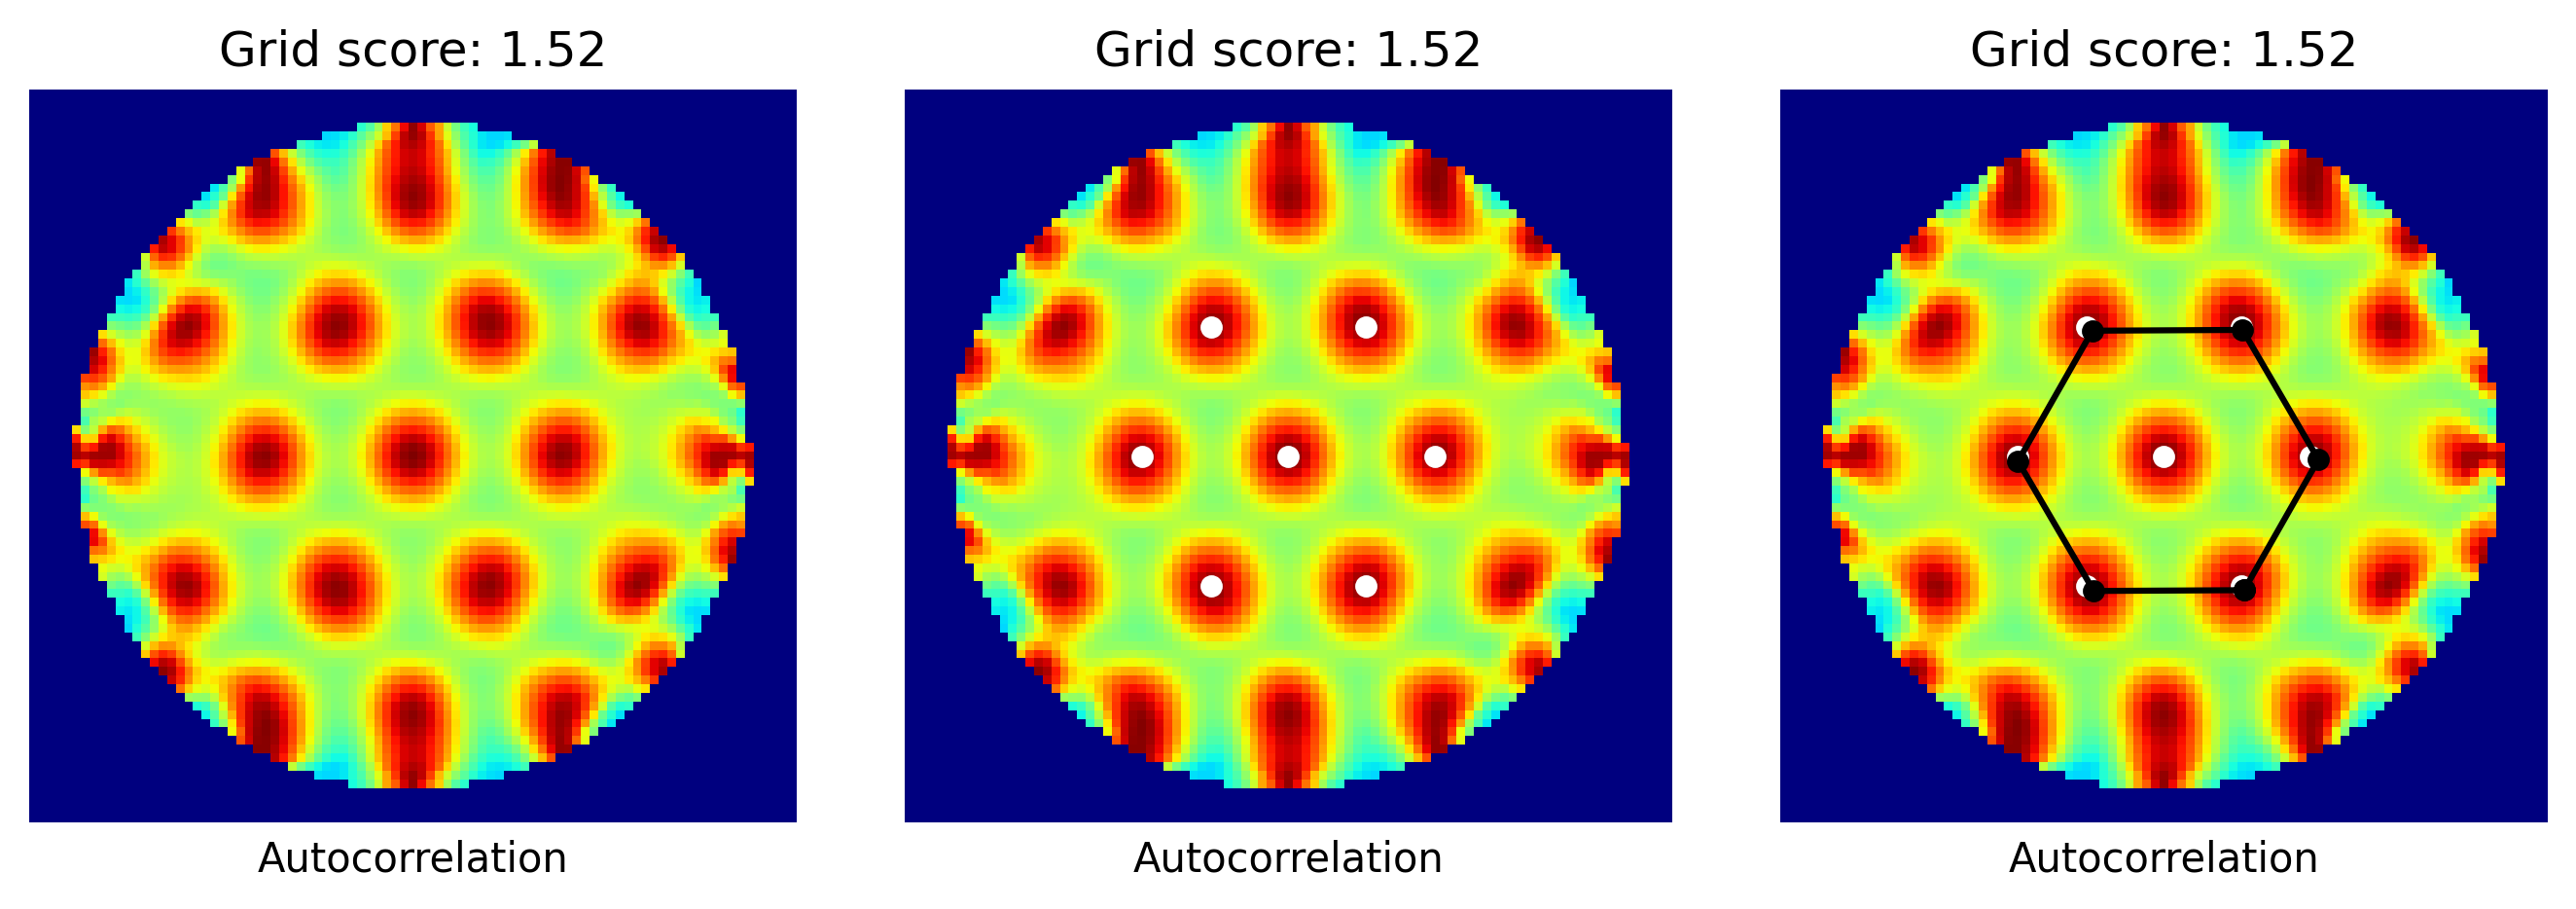

In [95]:
rowSize,colSize= 3,3
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) 
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
plt.rcParams['figure.dpi'] = 300

ax = fig.add_subplot(mainSpec[0,0])
plot_spatial_autocorrelation(ax,sgc)

ax = fig.add_subplot(mainSpec[0,1])
plot_spatial_autocorrelation(ax,sgc)
x_values, y_values = zip(*sgc.spatial_properties.points_inside_dougnut)
ax.scatter(y_values,x_values,s=20,color="white")


ax = fig.add_subplot(mainSpec[0,2])
plot_spatial_autocorrelation(ax,sgc)
x_R, y_R = zip(*rotatedHexagon)
ax.scatter(y_values,x_values,s=20,color="white")
ax.plot(y_R,x_R,color="black")
ax.scatter(y_R,x_R,s=20,color="black")

fig.savefig('../img/notebook2_example_grid_spacing_orientation.png')

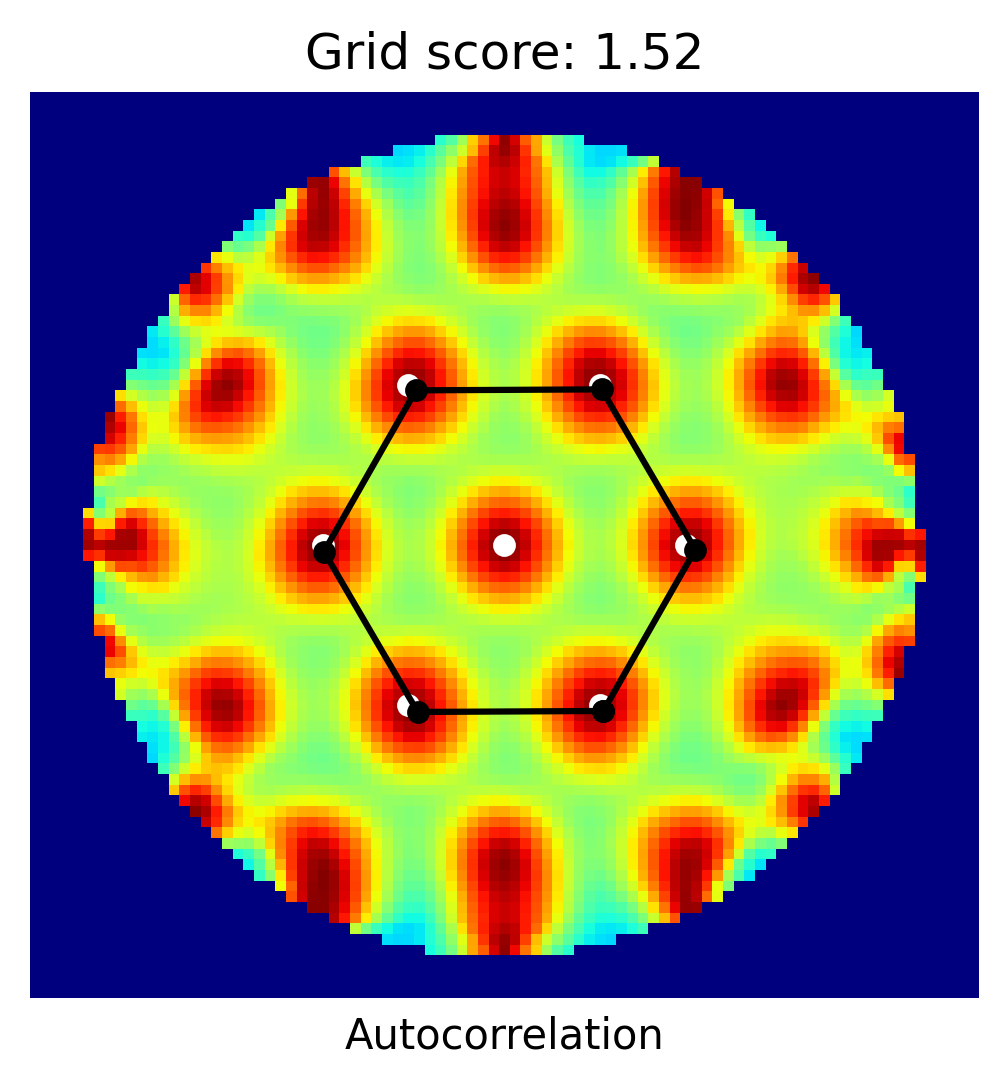

In [76]:
# Calculation of grid spacing:

fig, ax =plt.subplots()
plot_spatial_autocorrelation(ax,sgc)
#ax.scatter(sgc.spatial_properties.autocorr_midpoint[0],sgc.spatial_properties.autocorr_midpoint[1],s=20,color="green")


# Unzip the points into two lists
x_values, y_values = zip(*sgc.spatial_properties.points_inside_dougnut)
x_R, y_R = zip(*rotatedHexagon)

# Create a scatter plot
ax.scatter(y_values,x_values,s=20,color="white")
ax.plot(y_R,x_R,color="black")
ax.scatter(y_R,x_R,s=20,color="black")


(35.046201036526554, 0.5288876521194937, 3.3810526279631423, array([[44.58593294, 56.39445895],
       [34.43821528, 62.18190363],
       [24.35228233, 56.28744467],
       [24.41406706, 44.60554105],
       [34.56178472, 38.81809637],
       [44.64771767, 44.71255533],
       [44.58593294, 56.39445895]]))
Firing rate maps used to find grid cell parameters


  0%|          | 0/1 [00:00<?, ?it/s]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-41, -21]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


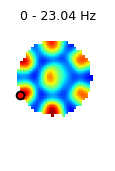

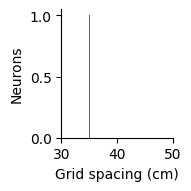

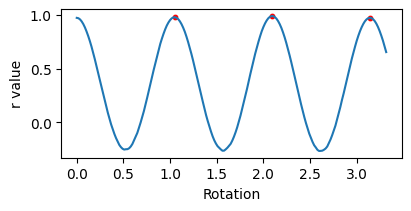

Visualize real and simulated grid pattern before fitting


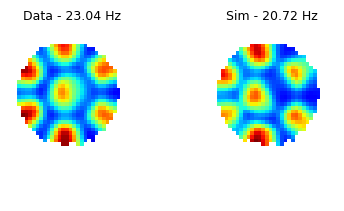

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 153.10365
Improvement of firing rate maps correlation after rigid fitting: from 0.668 to 0.983
Fitting more flexible grid cell model


KeyboardInterrupt: 

In [10]:
find_grid_cell_parameters(neuron_list[:1],save=False)

# Find the grid cell parameters for all cells

Firing rate maps used to find grid cell parameters


  0%|          | 0/20 [00:00<?, ?it/s]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-44,  -9]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


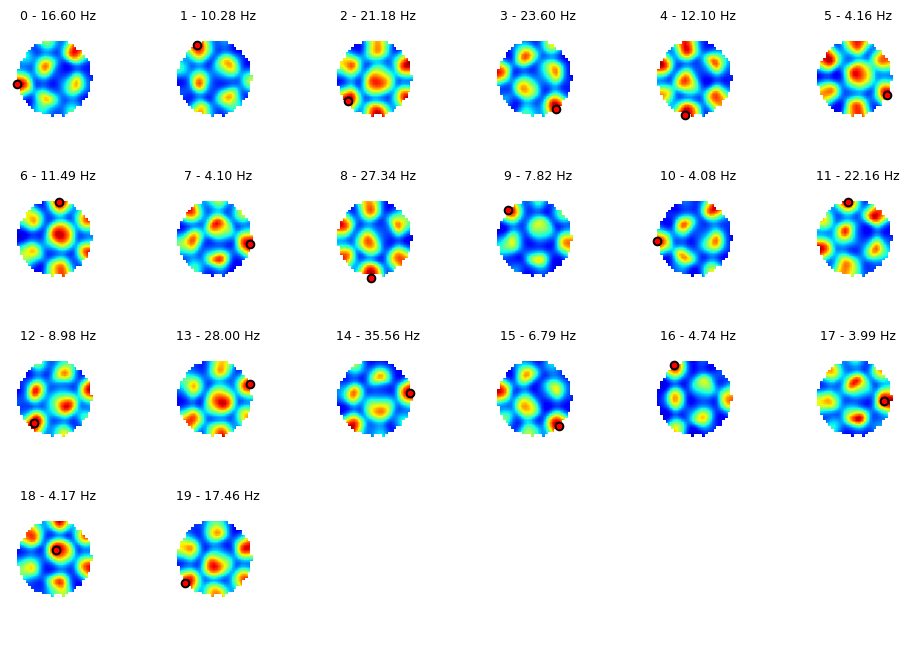

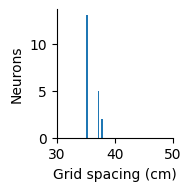

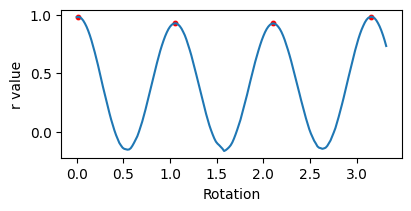

Visualize real and simulated grid pattern before fitting


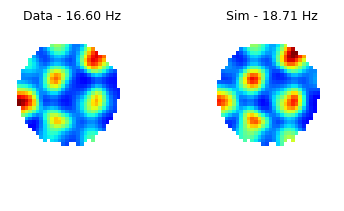

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 75.93861
Improvement of firing rate maps correlation after rigid fitting: from 0.887 to 0.921
Fitting more flexible grid cell model
Loss after flexible model fitting: 75.92113
Improvement of firing rate maps correlation after flexible fitting: from 0.921 to 0.952
Comparison of firing rate maps after fitting different models


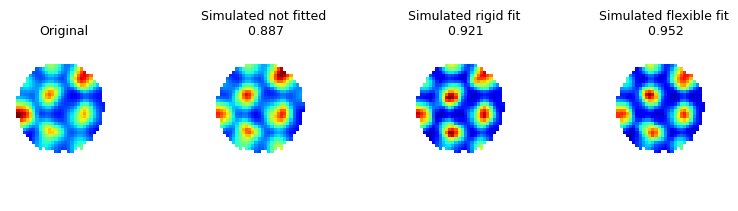

  5%|▌         | 1/20 [01:12<23:00, 72.67s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-23,  33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


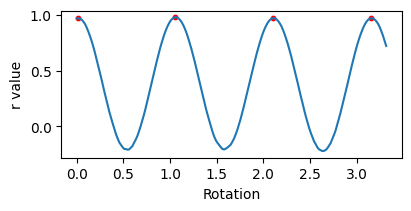

Visualize real and simulated grid pattern before fitting


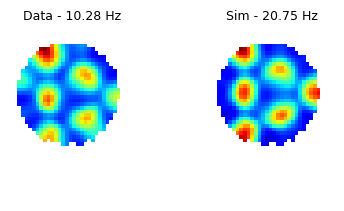

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 49.598576
Improvement of firing rate maps correlation after rigid fitting: from 0.702 to 0.952
Fitting more flexible grid cell model
Loss after flexible model fitting: 49.586872
Improvement of firing rate maps correlation after flexible fitting: from 0.952 to 0.954
Comparison of firing rate maps after fitting different models


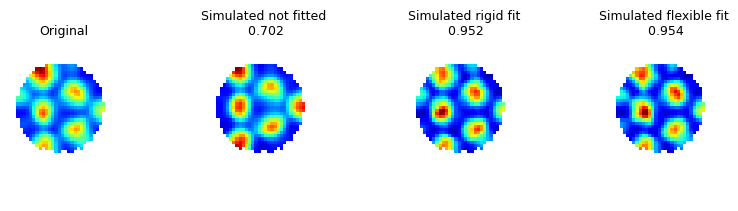

 10%|█         | 2/20 [02:24<21:40, 72.24s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([-32, -27]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


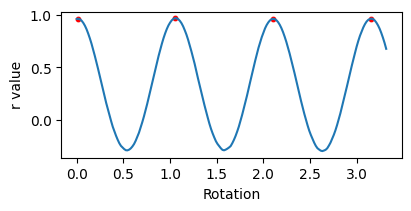

Visualize real and simulated grid pattern before fitting


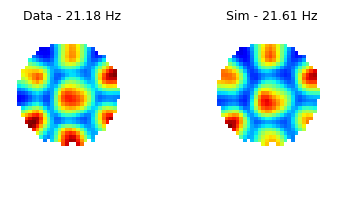

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 162.45493
Improvement of firing rate maps correlation after rigid fitting: from 0.909 to 0.970
Fitting more flexible grid cell model
Loss after flexible model fitting: 162.44237
Improvement of firing rate maps correlation after flexible fitting: from 0.970 to 0.974
Comparison of firing rate maps after fitting different models


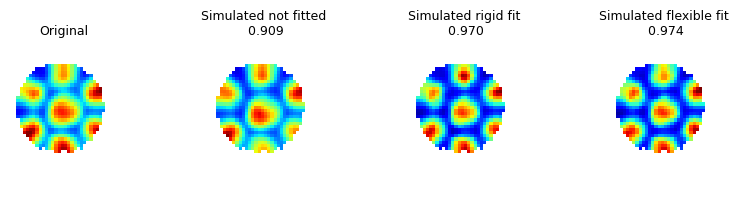

 15%|█▌        | 3/20 [03:35<20:21, 71.85s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([ 19, -36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


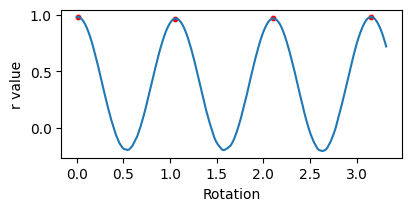

Visualize real and simulated grid pattern before fitting


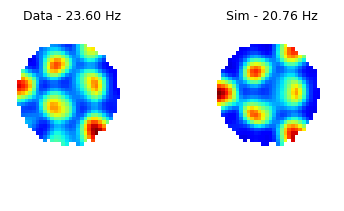

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 126.73363
Improvement of firing rate maps correlation after rigid fitting: from 0.740 to 0.965
Fitting more flexible grid cell model
Loss after flexible model fitting: 126.6826
Improvement of firing rate maps correlation after flexible fitting: from 0.965 to 0.974
Comparison of firing rate maps after fitting different models


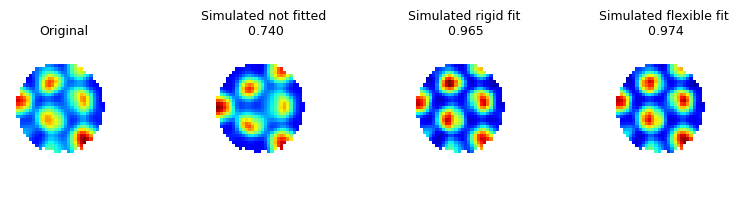

 20%|██        | 4/20 [04:47<19:05, 71.58s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-14, -42]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


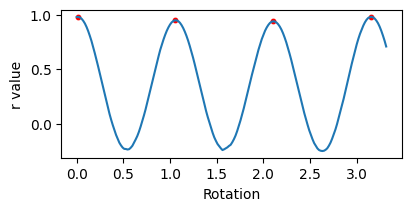

Visualize real and simulated grid pattern before fitting


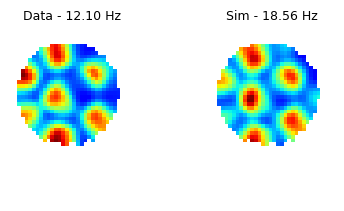

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 74.6099
Improvement of firing rate maps correlation after rigid fitting: from 0.733 to 0.960
Fitting more flexible grid cell model
Loss after flexible model fitting: 74.60923
Improvement of firing rate maps correlation after flexible fitting: from 0.960 to 0.960
Comparison of firing rate maps after fitting different models


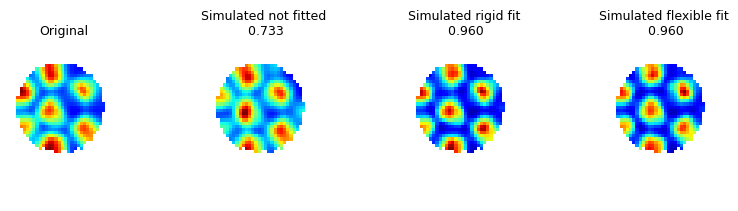

 25%|██▌       | 5/20 [05:57<17:45, 71.06s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([ 31, -21]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


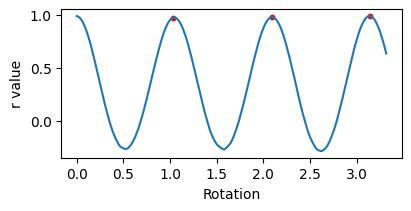

Visualize real and simulated grid pattern before fitting


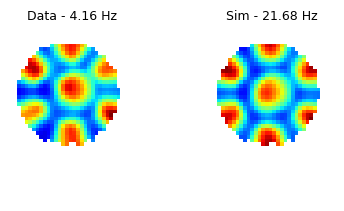

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 31.814478
Improvement of firing rate maps correlation after rigid fitting: from 0.874 to 0.928
Fitting more flexible grid cell model
Loss after flexible model fitting: 31.746487
Improvement of firing rate maps correlation after flexible fitting: from 0.928 to 0.939
Comparison of firing rate maps after fitting different models


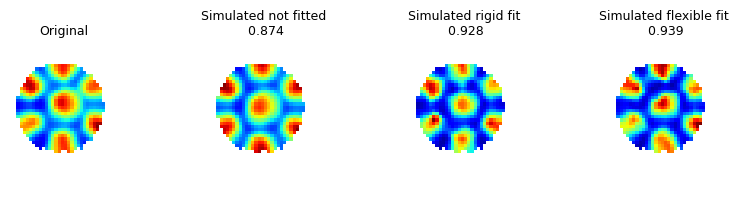

 30%|███       | 6/20 [07:07<16:32, 70.93s/it]

{'period': array([32.81051313, 32.81051313, 32.81051313]), 'offset': array([ 1, 36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


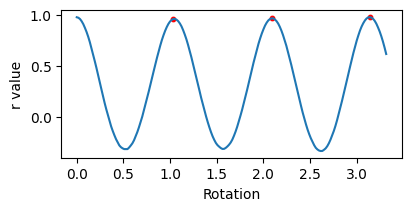

Visualize real and simulated grid pattern before fitting


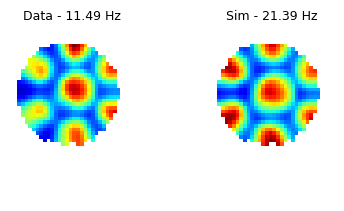

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 80.400185
Improvement of firing rate maps correlation after rigid fitting: from 0.827 to 0.956
Fitting more flexible grid cell model
Loss after flexible model fitting: 80.39444
Improvement of firing rate maps correlation after flexible fitting: from 0.956 to 0.957
Comparison of firing rate maps after fitting different models


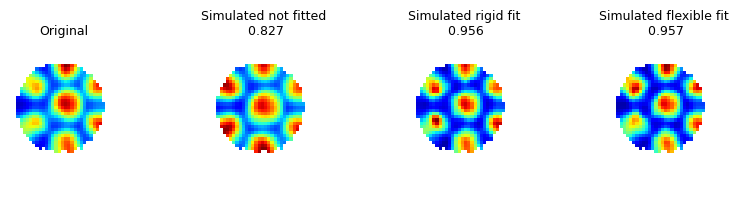

 35%|███▌      | 7/20 [08:18<15:21, 70.86s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([34, -9]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


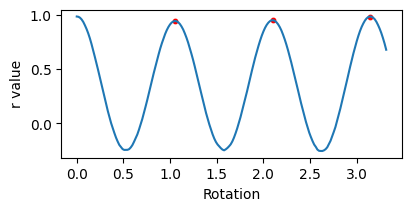

Visualize real and simulated grid pattern before fitting


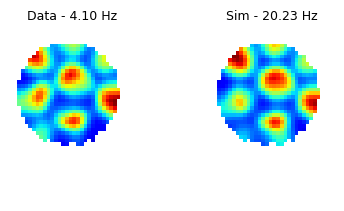

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 22.348978
Improvement of firing rate maps correlation after rigid fitting: from 0.860 to 0.941
Fitting more flexible grid cell model
Loss after flexible model fitting: 22.343311
Improvement of firing rate maps correlation after flexible fitting: from 0.941 to 0.951
Comparison of firing rate maps after fitting different models


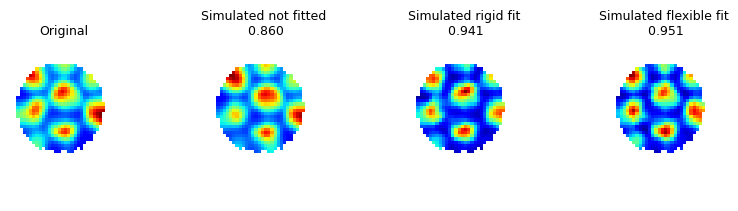

 40%|████      | 8/20 [09:31<14:16, 71.38s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([ -8, -45]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


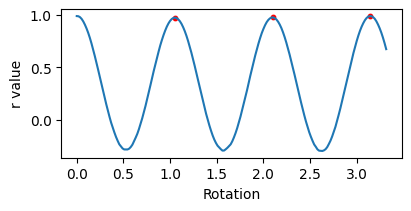

Visualize real and simulated grid pattern before fitting


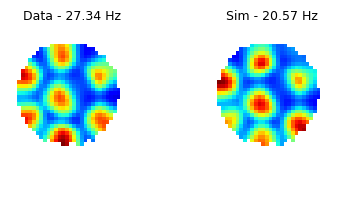

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 173.64587
Improvement of firing rate maps correlation after rigid fitting: from 0.808 to 0.973
Fitting more flexible grid cell model
Loss after flexible model fitting: 173.63426
Improvement of firing rate maps correlation after flexible fitting: from 0.973 to 0.966
Comparison of firing rate maps after fitting different models


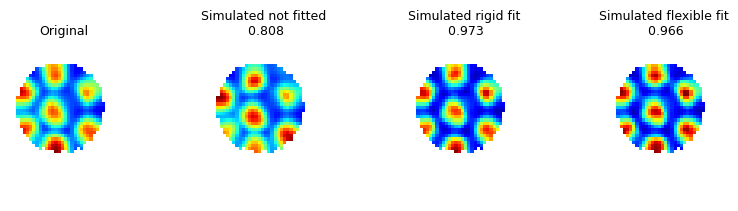

 45%|████▌     | 9/20 [10:42<13:03, 71.23s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-32,  27]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0174834598317883


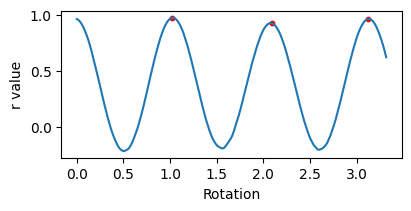

Visualize real and simulated grid pattern before fitting


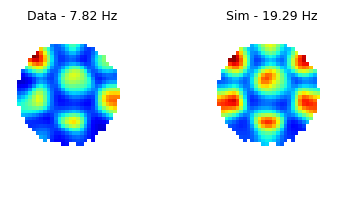

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 33.71515
Improvement of firing rate maps correlation after rigid fitting: from 0.789 to 0.919
Fitting more flexible grid cell model
Loss after flexible model fitting: 33.703392
Improvement of firing rate maps correlation after flexible fitting: from 0.919 to 0.949
Comparison of firing rate maps after fitting different models


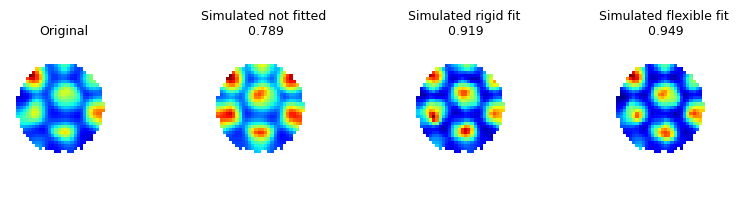

 50%|█████     | 10/20 [11:52<11:50, 71.05s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-44,  -6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


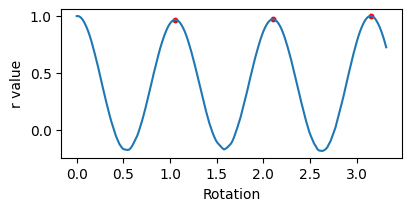

Visualize real and simulated grid pattern before fitting


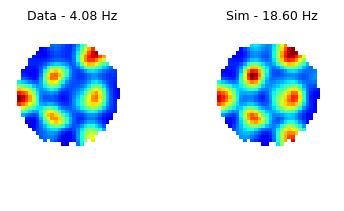

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 17.505762
Improvement of firing rate maps correlation after rigid fitting: from 0.951 to 0.934
Fitting more flexible grid cell model
Loss after flexible model fitting: 17.504406
Improvement of firing rate maps correlation after flexible fitting: from 0.934 to 0.906
Comparison of firing rate maps after fitting different models


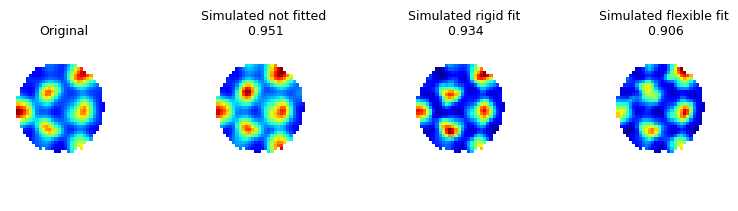

 55%|█████▌    | 11/20 [12:51<10:05, 67.32s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-11,  36]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


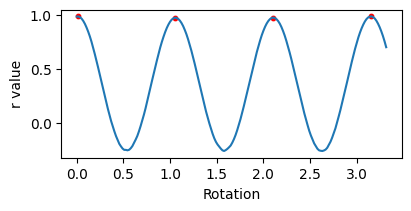

Visualize real and simulated grid pattern before fitting


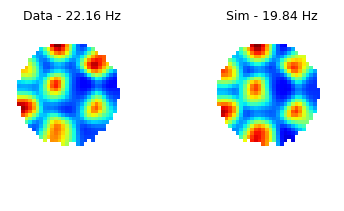

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 123.08113
Improvement of firing rate maps correlation after rigid fitting: from 0.905 to 0.960
Fitting more flexible grid cell model
Loss after flexible model fitting: 123.045334
Improvement of firing rate maps correlation after flexible fitting: from 0.960 to 0.958
Comparison of firing rate maps after fitting different models


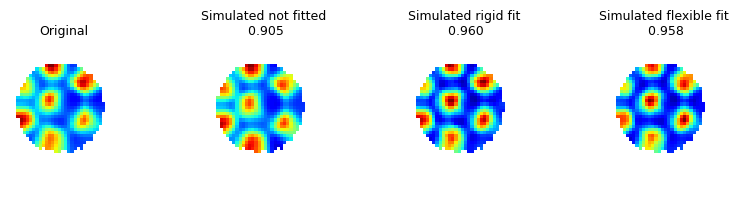

 60%|██████    | 12/20 [14:04<09:11, 68.89s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-26, -30]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


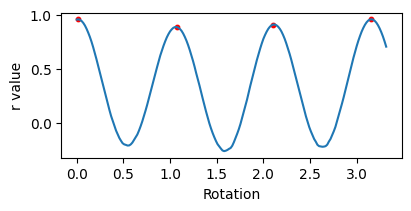

Visualize real and simulated grid pattern before fitting


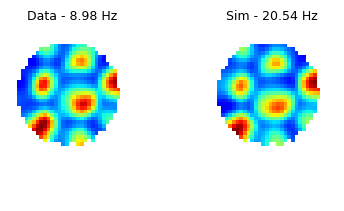

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 54.782463
Improvement of firing rate maps correlation after rigid fitting: from 0.868 to 0.953
Fitting more flexible grid cell model
Loss after flexible model fitting: 54.781406
Improvement of firing rate maps correlation after flexible fitting: from 0.953 to 0.940
Comparison of firing rate maps after fitting different models


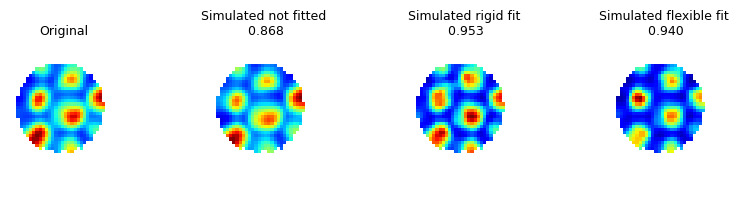

 65%|██████▌   | 13/20 [15:08<07:53, 67.60s/it]

{'period': array([32.81051313, 32.81051313, 32.81051313]), 'offset': array([34, 12]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


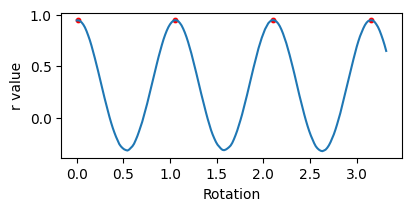

Visualize real and simulated grid pattern before fitting


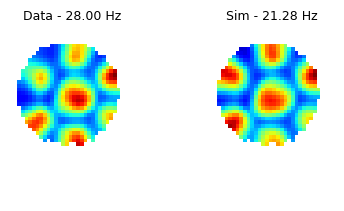

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 199.1372
Improvement of firing rate maps correlation after rigid fitting: from 0.838 to 0.961
Fitting more flexible grid cell model
Loss after flexible model fitting: 199.12134
Improvement of firing rate maps correlation after flexible fitting: from 0.961 to 0.953
Comparison of firing rate maps after fitting different models


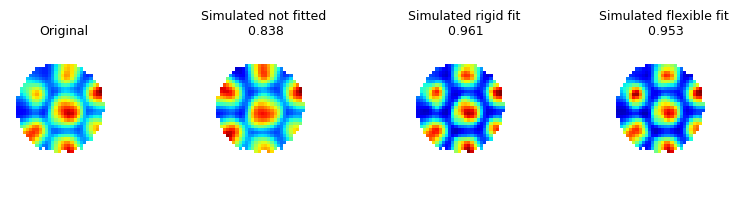

 70%|███████   | 14/20 [16:16<06:45, 67.54s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([34,  3]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


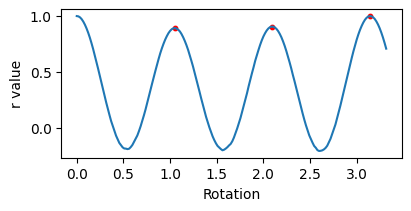

Visualize real and simulated grid pattern before fitting


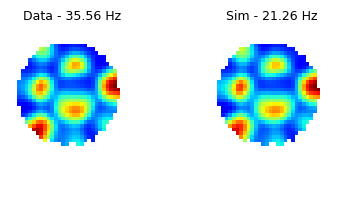

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 189.81604
Improvement of firing rate maps correlation after rigid fitting: from 0.991 to 0.958
Fitting more flexible grid cell model
Loss after flexible model fitting: 189.77853
Improvement of firing rate maps correlation after flexible fitting: from 0.958 to 0.958
Comparison of firing rate maps after fitting different models


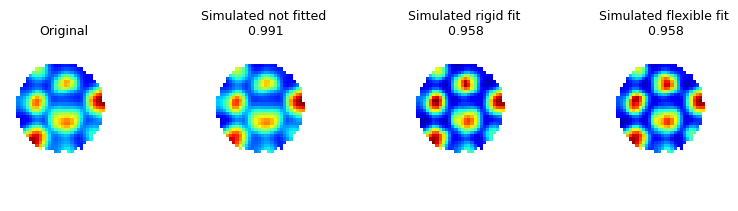

 75%|███████▌  | 15/20 [17:20<05:32, 66.52s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([ 22, -33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


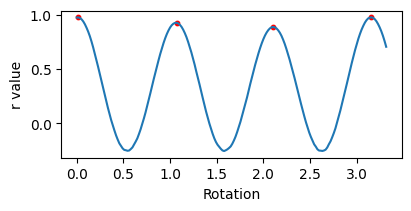

Visualize real and simulated grid pattern before fitting


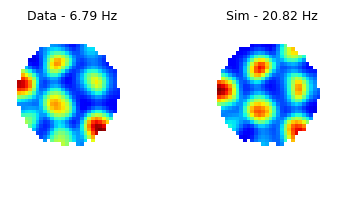

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 34.52722
Improvement of firing rate maps correlation after rigid fitting: from 0.749 to 0.931
Fitting more flexible grid cell model
Loss after flexible model fitting: 34.52408
Improvement of firing rate maps correlation after flexible fitting: from 0.931 to 0.935
Comparison of firing rate maps after fitting different models


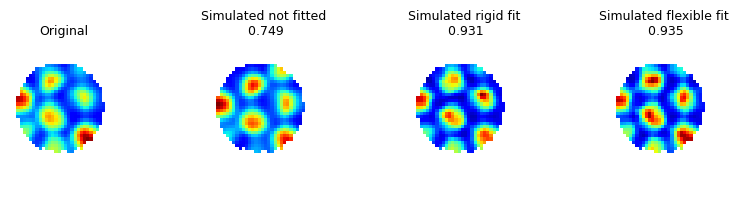

 80%|████████  | 16/20 [18:21<04:19, 64.90s/it]

{'period': array([30.3509004, 30.3509004, 30.3509004]), 'offset': array([-26,  33]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.0350262781047501


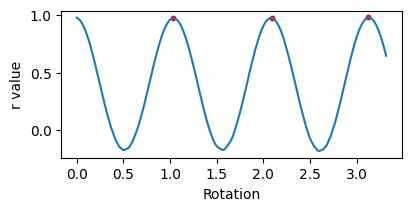

Visualize real and simulated grid pattern before fitting


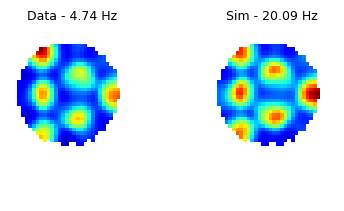

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 19.804016
Improvement of firing rate maps correlation after rigid fitting: from 0.898 to 0.925
Fitting more flexible grid cell model
Loss after flexible model fitting: 19.798727
Improvement of firing rate maps correlation after flexible fitting: from 0.925 to 0.923
Comparison of firing rate maps after fitting different models


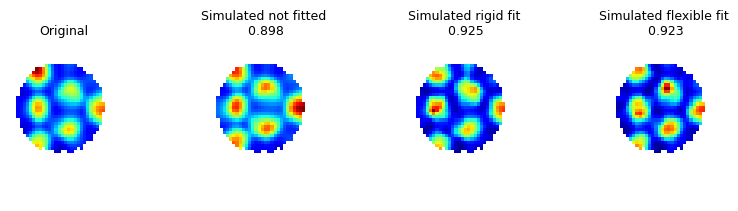

 85%|████████▌ | 17/20 [19:18<03:07, 62.65s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([28, -6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  0.017542818272961867


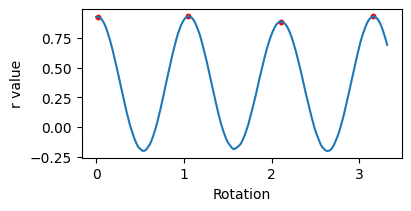

Visualize real and simulated grid pattern before fitting


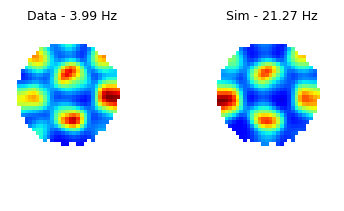

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 21.4479
Improvement of firing rate maps correlation after rigid fitting: from 0.812 to 0.925
Fitting more flexible grid cell model
Loss after flexible model fitting: 21.447187
Improvement of firing rate maps correlation after flexible fitting: from 0.925 to 0.937
Comparison of firing rate maps after fitting different models


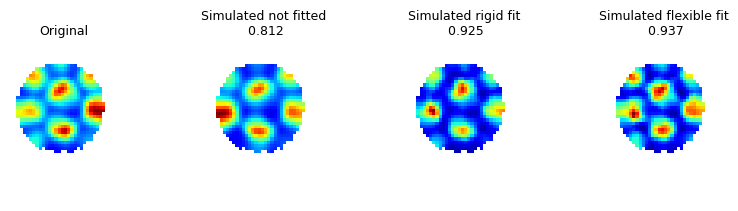

 90%|█████████ | 18/20 [20:18<02:03, 61.79s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([-2,  6]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


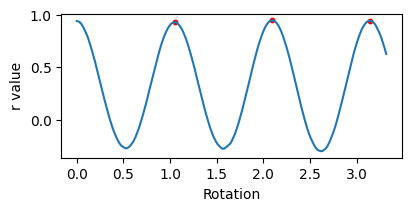

Visualize real and simulated grid pattern before fitting


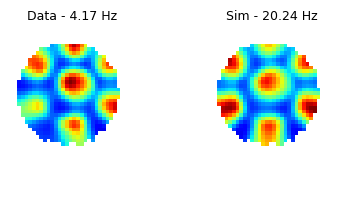

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 26.611555
Improvement of firing rate maps correlation after rigid fitting: from 0.786 to 0.944
Fitting more flexible grid cell model
Loss after flexible model fitting: 26.608599
Improvement of firing rate maps correlation after flexible fitting: from 0.944 to 0.945
Comparison of firing rate maps after fitting different models


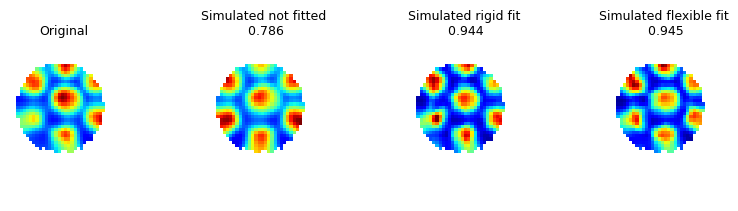

 95%|█████████▌| 19/20 [21:16<01:00, 60.60s/it]

{'period': array([32.29289874, 32.29289874, 32.29289874]), 'offset': array([-35, -30]), 'peak_rate': 25, 'orientation': array([0.        , 1.04719755, 2.0943951 ])}
Results after rotating the spatial autocorrelation
First axis at  1.052569096377712


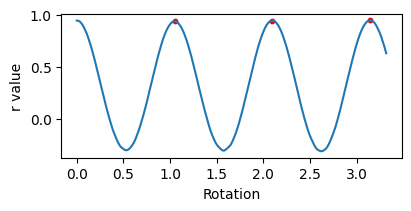

Visualize real and simulated grid pattern before fitting


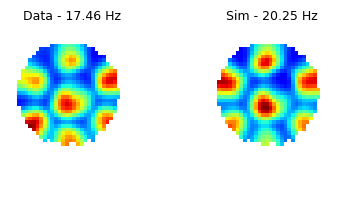

Shape of tensors used for training: torch.Size([87750, 2]) torch.Size([87750, 1])
Fitting rigid grid cell model
Loss after rigid model fitting: 119.446495
Improvement of firing rate maps correlation after rigid fitting: from 0.830 to 0.965
Fitting more flexible grid cell model
Loss after flexible model fitting: 119.440475
Improvement of firing rate maps correlation after flexible fitting: from 0.965 to 0.968
Comparison of firing rate maps after fitting different models


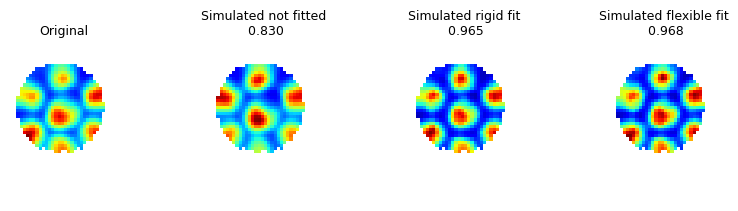

100%|██████████| 20/20 [22:15<00:00, 66.76s/it]

Saving: ../data/grid_cell_parameters.pkl


[{'name': '0',
  'grid_param_initial': {'period': array([30.3509004, 30.3509004, 30.3509004]),
   'offset': array([-44,  -9]),
   'peak_rate': 25,
   'orientation': array([0.01754282, 1.0525691 , 2.10513819])},
  'grid_param_model_rigid': {'period': array([30.388979, 30.388979, 30.388979], dtype=float32),
   'offset': array([-41.321434,  -8.780185], dtype=float32),
   'peak_rate': array([19.9434], dtype=float32),
   'orientation': array([0.00552261, 1.05272016, 2.09991771])},
  'loss_rigid': array(75.93861, dtype=float32),
  'r_rigid': 0.9207692188536325,
  'grid_param_model_flexible': {'period': array([30.179018, 30.320965, 30.464663], dtype=float32),
   'offset': array([-41.06191 ,  -8.597529], dtype=float32),
   'peak_rate': array([19.954393], dtype=float32),
   'orientation': array([0.00973757, 1.0460675 , 2.0994031 ], dtype=float32)},
  'loss_flexible': array(75.92113, dtype=float32),
  'r_flexible': 0.9518030854799242},
 {'name': '1',
  'grid_param_initial': {'period': array([30.

In [ ]:
find_grid_cell_parameters(neuron_list)